In [1]:
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
def capture_image_from_webcam(save_path='captured_image.jpg'):
    cap=cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('not opening')
    print('space to capture q to quit')
    img=None
    while True:
        ret,frame=cap.read()
        if not ret:
            print('failed to grab frame')
            break
        cv2.imshow('Webcam - press SPACE to capture', frame)

        k=cv2.waitKey(1)
        if k%256==32:
            img=frame.copy()
            cv2.imwrite(save_path,img)
            break
        elif k%256== ord('q'):
            print('image not taken')
            img = None
            break
    cap.release()
    cv2.destroyAllWindows()
    return save_path if img is not None  else None
    
captured= capture_image_from_webcam()

if os.path.exists('captured_image.jpg'):
    img_bgr=cv2.imread('captured_image.jpg')
    img_rgb=cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("captured image")
    plt.show()

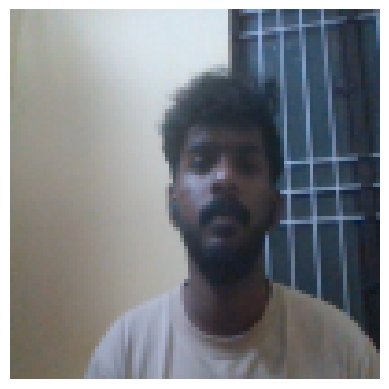

In [4]:
import cv2
import matplotlib.pyplot as plt
import os

cap = cv2.VideoCapture(0)  # 0 = default webcam
ret, frame = cap.read()
cap.release()

if not ret:
    raise Exception("Could not capture image from webcam")

# Convert from BGR (OpenCV default) to RGB
imag = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image = cv2.resize(imag, (100,100), interpolation=cv2.INTER_AREA)

plt.imshow(image)
plt.axis('off')
plt.savefig('captured.jpg')

plt.show()


In [5]:
h,w,c=image.shape
image.shape

(100, 100, 3)

In [6]:
img_proc=image.copy()

In [7]:
pixels=img_proc.reshape(-1,3).astype(float)
pixels

array([[154., 158., 146.],
       [156., 158., 153.],
       [160., 157., 143.],
       ...,
       [ 97.,  95.,  81.],
       [107., 101.,  96.],
       [107., 104., 100.]], shape=(10000, 3))

In [8]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
pixels_scaled=scaler.fit_transform(pixels)

In [9]:
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering

km=KMeans(n_clusters=2,random_state=42)
klabels=km.fit_predict(pixels_scaled)



In [17]:
agg=AgglomerativeClustering(n_clusters=2,linkage='ward')
agg_labels=agg.fit_predict(pixels_scaled)

In [11]:
db=DBSCAN(metric='euclidean',eps=0.5,min_samples=5)
db_labels=db.fit_predict(pixels_scaled)

In [12]:
import numpy as np
np.unique(klabels)

array([0, 1], dtype=int32)

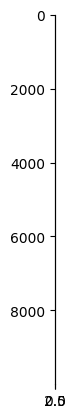

In [13]:
segmented_img=np.copy(pixels_scaled)
segmented_img = (segmented_img * 255).astype(np.uint8)

segmented_img[klabels==1]=[255,255,255]
segmented_img[klabels==-1]=[255,0,0]
segmented_img.reshape(h,w,c)
plt.imshow(segmented_img)
plt.show()

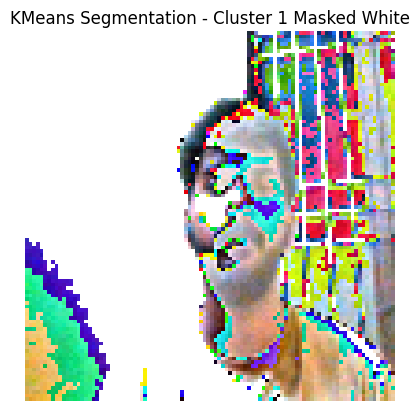

In [14]:
egmented_img = img_proc.reshape(-1, c).copy()

# Mask one cluster (example: cluster 1 becomes white)
segmented_img[klabels == 1] = [255, 255, 255]

# Reshape back to image
segmented_img = segmented_img.reshape(h, w, c)

# Show
plt.imshow(segmented_img)
plt.axis('off')
plt.title("KMeans Segmentation - Cluster 1 Masked White")
plt.show()

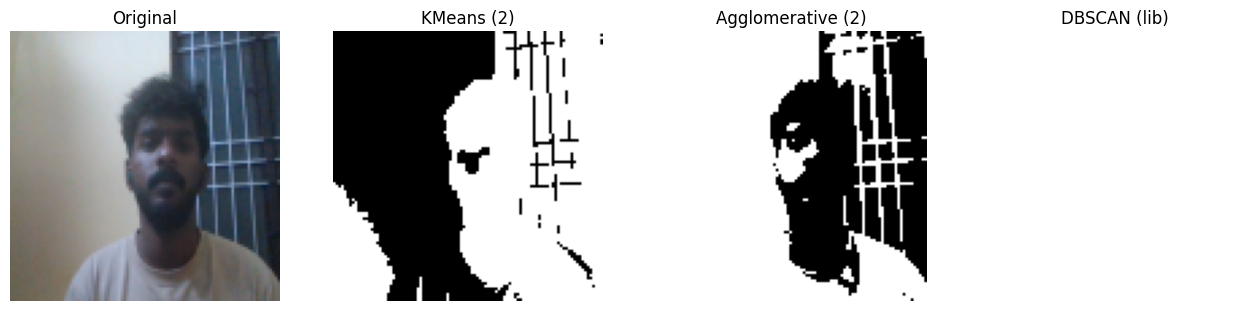

In [20]:
def labels_to_segment_image(labels, image_shape, cluster_colors=None):
    # labels: -1 for noise possibly; map labels to 0..k-1
    unique = np.unique(labels)
    # Map labels to consecutive indices
    mapping = {lab: i for i, lab in enumerate(unique)}
    mapped = np.vectorize(mapping.get)(labels)
    if cluster_colors is None:
        # default: cluster 0 -> white, cluster 1 -> black, others -> shades
        cluster_colors = [(255,255,255), (0,0,0)]
        # extend if needed
        for i in range(len(unique)-len(cluster_colors)):
            cluster_colors.append(tuple(np.random.randint(0,256,3).tolist()))
    seg = np.zeros((labels.shape[0], 3), dtype=np.uint8)
    for lab, idx in mapping.items():
        seg[mapped==idx] = cluster_colors[idx]
    return seg.reshape(image_shape).astype(np.uint8)

# Visualize results side-by-side
fig, axs = plt.subplots(1,4, figsize=(16,5))
axs[0].imshow(img_proc); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(labels_to_segment_image(klabels, img_proc.shape)); axs[1].set_title('KMeans (2)'); axs[1].axis('off')
axs[2].imshow(labels_to_segment_image(agg_labels, img_proc.shape)); axs[2].set_title('Agglomerative (2)'); axs[2].axis('off')
# For DBSCAN, noise label is -1; show it in blue if present
db_colors = [(255,255,255),(0,0,0)]
if -1 in np.unique(db_labels):
    # ensure a color for noise
    db_colors.append((0,0,255))
axs[3].imshow(labels_to_segment_image(db_labels, img_proc.shape, cluster_colors=db_colors)); axs[3].set_title('DBSCAN (lib)'); axs[3].axis('off')
plt.show()

In [21]:
cv2.imwrite('seg_kmeans.jpg', cv2.cvtColor(labels_to_segment_image(klabels, img_proc.shape), cv2.COLOR_RGB2BGR))
cv2.imwrite('seg_agg_lib.jpg', cv2.cvtColor(labels_to_segment_image(agg_labels, img_proc.shape), cv2.COLOR_RGB2BGR))
print('Saved segmented images: seg_kmeans.jpg, seg_agg_lib.jpg, seg_db_lib.jpg')

Saved segmented images: seg_kmeans.jpg, seg_agg_lib.jpg, seg_db_lib.jpg
